# Import 

In [135]:
import os
import json
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances
import cv2
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster, linkage
from collections import defaultdict


# Indexing artist folders with metadata

Parses folder names to extract artist info and builds a JSON index of all `.jpg` paintings, including image size and artist metadata.


In [121]:
def parse_folder_name(folder_name):
    """
    Parses a painter folder name to extract artist information.
    
    Args:
        folder_name (str): Folder name in format "CODE - NAME_BIRTHYEAR"
    
    Returns:
        dict: Dictionary containing artist code, full name and birth year
              Returns None if parsing fails
    """
    try:
        code, remainder = folder_name.split(" - ")
        name, birth_year = remainder.rsplit("_", 1)
        return {
            "artist_code": code.strip(),
            "full_name": name.strip(),
            "birth_year": int(birth_year)
        }
    except Exception as e:
        print(f"Error parsing folder: {folder_name} — {e}")
        return None

def create_index(base_dir="../bd-peintres-v6", index_file="index.json"):
    """
    Creates an index of all paintings with metadata including image dimensions.
    
    Args:
        base_dir (str): Path to directory containing artist folders
        index_file (str): Path to save the JSON index file
    
    Returns:
        dict: The created index dictionary with added image dimensions
    """
    base_path = Path(base_dir)
    index = {}

    for painter_folder in base_path.iterdir():
        if painter_folder.is_dir():
            meta = parse_folder_name(painter_folder.name)
            if not meta:
                continue
                
            images = list(painter_folder.glob("*.jpg"))
            for img_path in images:
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        
                    index[str(img_path)] = {
                        "artist_code": meta["artist_code"],
                        "full_name": meta["full_name"],
                        "birth_year": meta["birth_year"],
                        "width": width,
                        "height": height
                    }
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    continue

    with open(index_file, "w", encoding="utf-8") as f:
        json.dump(index, f, indent=2)

    return index

# Custom PyTorch Dataset for Paintings

Loads paintings with artist metadata and returns image tensors with numerical artist labels for training.


In [122]:
class PaintingDataset(Dataset):
    """PyTorch dataset for loading paintings with artist metadata.
    
    Args:
        image_paths (list): List of paths to painting images
        full_index (dict): Dictionary containing metadata for all paintings
        transform (callable, optional): Optional transform to be applied to images
    """
    
    def __init__(self, image_paths, full_index, transform=None):
        self.image_paths = image_paths
        self.index = full_index
        self.transform = transform
        
        # Create mapping from artist codes to numerical labels
        self.artist_codes = sorted(list({self.index[p]["artist_code"] for p in self.image_paths}))
        self.label_map = {code: idx for idx, code in enumerate(self.artist_codes)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Loads and returns a single painting with its label.
        
        Args:
            idx (int): Index of the painting to load
            
        Returns:
            tuple: (image_tensor, label) where label is the artist's numerical ID
        """
        path = self.image_paths[idx]
        
        # Load image
        img = Image.open(path).convert("RGB")
        
        # Apply transforms if specified
        if self.transform:
            img = self.transform(img)
        
        # Convert to tensor if not already transformed
        if isinstance(img, Image.Image):
            img = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
        
        # Get artist label
        label = self.label_map[self.index[path]["artist_code"]]
        
        return img, label

    @property
    def num_classes(self):
        """Returns the number of unique artists in the dataset."""
        return len(self.artist_codes)

# Image transform & index loader

Defines an image preprocessing pipeline for model input and loads (or creates) the painting metadata index.


In [123]:
def create_image_transform(target_size=(224, 224)):
    """
    Creates a transformation pipeline to prepare images for the model.
    
    Args:
        target_size (tuple): Desired output size (height, width)
        
    Returns:
        callable: Function that takes PIL Image and returns normalized tensor
    """
    def transform(img):
        # Resize image
        img = img.resize(target_size)
        # Convert to numpy array
        img_array = np.array(img)
        # Convert to tensor and normalize [0,255] -> [0,1]
        img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float() / 255.0
        return img_tensor
    
    return transform

def load_or_create_index(index_path="index.json"):
    """
    Loads existing index or creates new one if not found.
    
    Args:
        index_path (str): Path to index JSON file
        
    Returns:
        dict: The loaded or created index
    """
    try:
        with open(index_path, "r") as f:
            index = json.load(f)
        print("Loaded existing index file.")
    except FileNotFoundError:
        print("Index not found. Creating new index...")
        index = create_index()
    return index

In [124]:
index = load_or_create_index()

Loaded existing index file.


# Display a painting with metadata

Shows a painting from the index along with artist info, dimensions, and filename. Supports random or specific selection.


In [ ]:
def plot_painting(index, idx=None):
    """
    Displays a painting image with its metadata from the index.
    
    Args:
        index (dict): The index dictionary containing paths and metadata
        idx (int/str, optional): Either an integer index or direct image path. 
                               If None, displays random painting.
    
    Displays:
        - The painting image
        - Filename as title
        - Artist information
    """
    # Handle different input types
    if isinstance(idx, str):  # Direct path provided
        path = idx
    elif isinstance(idx, int):  # Numerical index provided
        path = list(index.keys())[idx]
    else:  # Random selection if no index specified
        keys_list = list(index.keys())
        random_idx = np.random.randint(0, len(keys_list))
        path = keys_list[random_idx]
        print(f"Randomly selected index: {random_idx}")
        
    
    # Load and convert image
    img = Image.open(path).convert("RGB")
    
    # Get metadata
    metadata = index[path]
    
    info_text = (f"Artist: {metadata['full_name']}\n"
                 f"Code: {metadata['artist_code']}\n"
                 f"Birth Year: {metadata['birth_year']}\n"
                 f"Dimensions: {metadata['width']}x{metadata['height']}")
    print(info_text)
    # Create figure
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    
    # Add title with filename
    plt.title(f"Painting: {Path(path).name}", pad=20)
    plt.show()

Randomly selected index: 6467
Artist: rembrandt-van-rijn
Code: rembrandt
Birth Year: 1606
Dimensions: 1483x1800


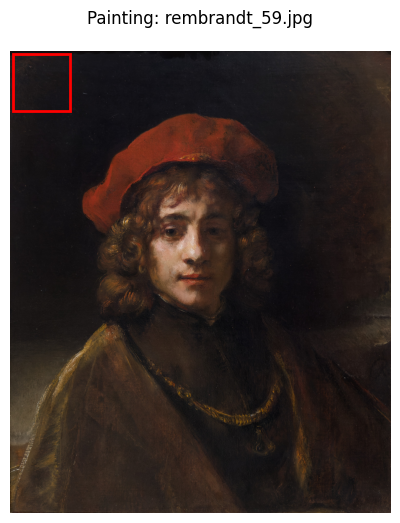

In [ ]:
plot_painting(index) # random if no index provided

# Formation of Perfect Rectangular Clusters
This section of the code transforms each group of similar patches into a perfect rectangular or square shape, ideal for use with deep learning models.

- Each rectangle has dimensions proportional to the patch size (typically 224×224), ensuring compatibility with standard CNN input formats.

- The algorithm computes the bounding rectangle of each cluster based on patch positions.

- It then fills the entire rectangle, by:

    - Including only the patches that are sufficiently similar to the core cluster (based on color histogram similarity).

    - Ignoring patches that are too dissimilar.

- The result is a set of clean, perfect rectangular regions — even if that means adding or skipping patches — ready for training or inference.

- Overlapping between clusters is allowed, and the full image is preserved.

In [127]:
def get__patches(index, idx=None, patch_size=224, show=False):
    def mirror_pad_single_side(img, original_width, original_height):
        img_np = np.array(img)

        if original_height > original_width:
            pad = original_height - original_width
            mirror = img_np[:, -1*pad:][:, ::-1]
            img_np = np.concatenate([img_np, mirror], axis=1)  # pad to the right
        elif original_width > original_height:
            pad = original_width - original_height
            mirror = img_np[-1*pad:, :][::-1, :]
            img_np = np.concatenate([img_np, mirror], axis=0)  # pad to the bottom

        return Image.fromarray(img_np)

    # --- Step 1: get image path ---
    if isinstance(idx, str):
        path = idx
    elif isinstance(idx, int):
        path = list(index.keys())[idx]
    else:
        keys_list = list(index.keys())
        random_idx = np.random.randint(0, len(keys_list))
        path = keys_list[random_idx]
        print(f"Randomly selected index: {random_idx}")

    # --- Step 2: load image and get dimensions ---
    img = Image.open(path).convert("RGB")
    w, h = img.size
    img = mirror_pad_single_side(img, w, h)

    # --- Step 3: crop to multiple of patch size ---
    side = img.size[0]  # image is square now
    crop_size = side - (side % patch_size)
    img = img.crop((0, 0, crop_size, crop_size))
    img_np = np.array(img)

    # --- Step 4: extract all patches ---
    patches_list = []
    positions = []
    variances = []
    
    for y in range(0, crop_size, patch_size):
        for x in range(0, crop_size, patch_size):
            patch = img_np[y:y+patch_size, x:x+patch_size]
            patch_var = np.var(patch) if len(patch.shape) == 2 else np.var(patch, axis=(0,1)).mean()
            
            patches_list.append(patch)
            positions.append((x, y))
            variances.append(patch_var)

    # --- Step 5: Show image with patches if requested ---
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Painting: {Path(path).name}\nPatch size: {patch_size}", pad=20)

        ax = plt.gca()
        for pos in positions:
            ax.add_patch(patches.Rectangle(pos, patch_size, patch_size, 
                                         linewidth=0.5, edgecolor='white', 
                                         facecolor='none', alpha=0.5))
        plt.show()

    return {
        'image': img_np,
        'patches': patches_list,
        'positions': positions,
        'variances': variances,
        'image_path': path,
        'patch_size': patch_size,
        'crop_size': crop_size
    }

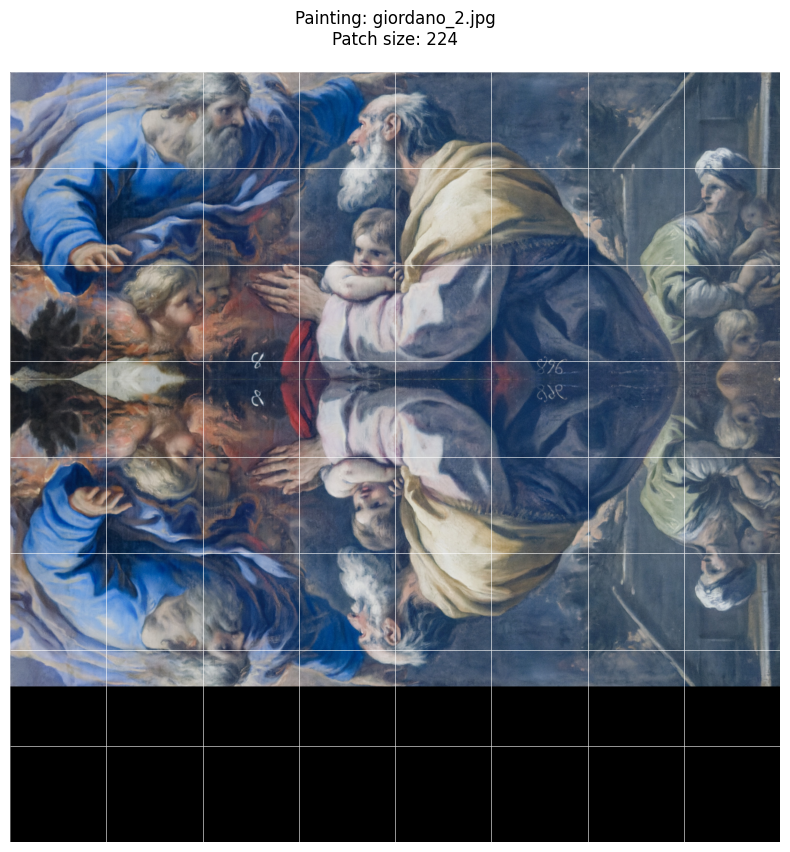

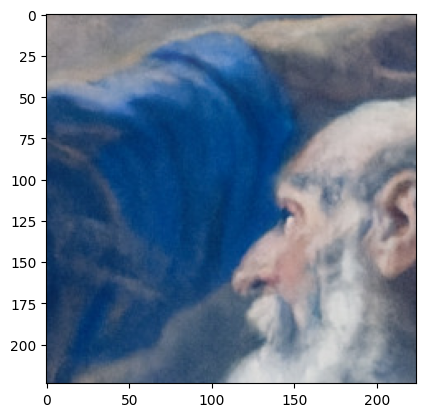

In [128]:
dict_patches=get__patches(index,idx=3233,show=True)  
plt.imshow(dict_patches['patches'][3])

In [146]:
def group_rectangular_similar_patches(patches_dict, threshold=0.2, show=False):
    """
    Regroupe les patches similaires et adjacents en formes rectangulaires/carrées.
    
    Args:
        patches_dict: Dictionnaire retourné par get__patches()
        threshold: Seuil de similarité (0-1), plus petit = regroupement plus strict
        show: Afficher le résultat si True
    
    Returns:
        Dictionnaire contenant les clusters rectangulaires
    """
    # Extraire les données
    patches_list = patches_dict['patches']
    positions = patches_dict['positions']
    img_np = patches_dict['image']
    patch_size = patches_dict['patch_size']
    
    # 1. Calculer les histogrammes couleur normalisés
    histograms = []
    for patch in patches_list:
        if len(patch.shape) == 3:  # Couleur
            hist = np.concatenate([
                cv2.calcHist([patch], [0], None, [8], [0, 256]).flatten(),
                cv2.calcHist([patch], [1], None, [8], [0, 256]).flatten(),
                cv2.calcHist([patch], [2], None, [8], [0, 256]).flatten()
            ])
        else:  # Niveaux de gris
            hist = cv2.calcHist([patch], [0], None, [8], [0, 256]).flatten()
        histograms.append(hist / (patch_size * patch_size))

    # 2. Calculer la matrice de similarité (cosinus)
    similarity_matrix = 1 - pairwise_distances(histograms, metric='cosine')
    
    # 3. Construire le graphe d'adjacence
    n = len(positions)
    adj_graph = {i: set() for i in range(n)}
    grid = {(x//patch_size, y//patch_size): i for i, (x,y) in enumerate(positions)}
    
    for (x,y), i in grid.items():
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:  # 4-connexité
            if (x+dx, y+dy) in grid:
                j = grid[(x+dx, y+dy)]
                adj_graph[i].add(j)
                adj_graph[j].add(i)
    
    # 4. Algorithme de regroupement initial
    visited = set()
    labels = np.zeros(n, dtype=int)
    current_label = 0
    
    for i in range(n):
        if i not in visited:
            queue = [i]
            visited.add(i)
            labels[i] = current_label
            
            while queue:
                node = queue.pop(0)
                for neighbor in adj_graph[node]:
                    if (neighbor not in visited and 
                        similarity_matrix[node, neighbor] >= (1 - threshold)):
                        visited.add(neighbor)
                        labels[neighbor] = current_label
                        queue.append(neighbor)
            
            current_label += 1
    
    # 5. Formation de clusters parfaitement rectangulaires
        from collections import defaultdict

    cluster_positions = defaultdict(list)
    for idx, label in enumerate(labels):
        cluster_positions[label].append(positions[idx])

    rectangular_clusters = []
    new_labels = np.zeros_like(labels)
    current_label = 0

    for cluster_id, original_positions in cluster_positions.items():
        if len(original_positions) < 2:
            continue

        # Coordonnées en grille
        grid_coords = {(x // patch_size, y // patch_size) for x, y in original_positions}
        min_x = min(x for x, y in grid_coords)
        max_x = max(x for x, y in grid_coords)
        min_y = min(y for x, y in grid_coords)
        max_y = max(y for x, y in grid_coords)

        # Rectangle englobant
        full_rect_coords = [(x, y) for x in range(min_x, max_x + 1) for y in range(min_y, max_y + 1)]

        # Indices initiaux pour calculer la similarité
        core_indices = [grid[(x, y)] for (x, y) in grid_coords if (x, y) in grid]
        if not core_indices:
            continue

        accepted_positions = []
        for (x, y) in full_rect_coords:
            if (x, y) in grid:
                idx = grid[(x, y)]
                # Moyenne de similarité avec le noyau
                similarities = [similarity_matrix[idx, j] for j in core_indices if j != idx]
                avg_sim = np.mean(similarities) if similarities else 0
                if avg_sim >= (1 - threshold):
                    accepted_positions.append((x * patch_size, y * patch_size))
            else:
                # Pas de patch original à cette position → à ignorer
                continue

        # Compléter le rectangle même si tous les patches ne sont pas dans le cluster initial
        for (x, y) in full_rect_coords:
            px, py = x * patch_size, y * patch_size
            if (x, y) in grid:
                idx = grid[(x, y)]
                new_labels[idx] = current_label
            accepted_positions.append((px, py))  # On complète visuellement

        # Stockage du rectangle
        width = (max_x - min_x + 1) * patch_size
        height = (max_y - min_y + 1) * patch_size
        rect_x = min_x * patch_size
        rect_y = min_y * patch_size

        rectangular_clusters.append({
            'rect': (rect_x, rect_y, width, height),
            'positions': accepted_positions,
            'perfect': True
        })

        current_label += 1

    # 6. Visualisation
    if show:
        plt.figure(figsize=(12, 12))
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f"Clusters rectangulaires stricts (seuil={threshold})", pad=20)
        
        ax = plt.gca()
        colors = plt.cm.get_cmap('tab10', len(rectangular_clusters))
        
        for cluster_id, cluster in enumerate(rectangular_clusters):
            x, y, width, height = cluster['rect']
            
            # Dessiner le rectangle
            rect = patches.Rectangle(
                (x, y), width, height,
                linewidth=2,
                edgecolor=colors(cluster_id),
                facecolor='none',
                alpha=0.7
            )
            ax.add_patch(rect)
            
            # Marquer les rectangles non-parfaits
            if not cluster['perfect']:
                ax.add_patch(patches.Rectangle(
                    (x, y), width, height,
                    linewidth=1,
                    edgecolor='red',
                    facecolor='none',
                    linestyle='--',
                    alpha=0.5
                ))
        
        plt.show()
    
    return {
        'labels': new_labels,
        'n_clusters': len(rectangular_clusters),
        'rectangles': [cluster['rect'] for cluster in rectangular_clusters],
        'cluster_info': {
            i: {
                'rectangle': cluster['rect'],
                'perfect': cluster['perfect'],
                'size': len(cluster['positions']),
                'positions': cluster['positions']
            }
            for i, cluster in enumerate(rectangular_clusters)
        }
    }

idx de test : 
- 8054 marche plutot bien pour threshold a 0.15
- 8196 marche pas a 0.15 mais bien à 0.05
- 3233 enlever les clusters ou il y a trop de noir
- 6467 vraiment bien
- 4650


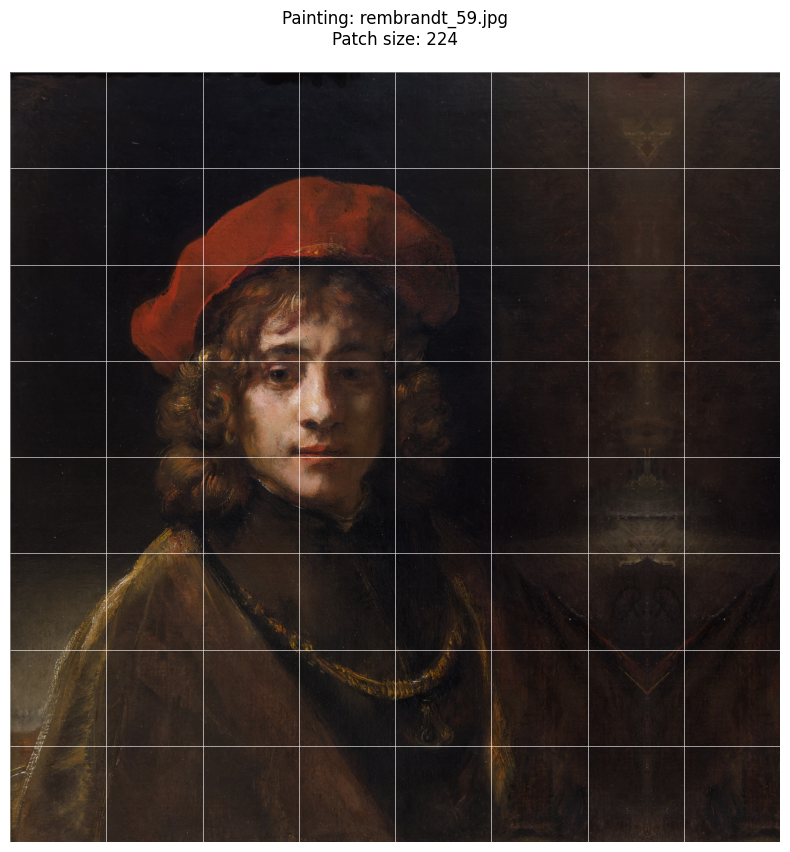

C:\Users\Titouan\AppData\Local\Temp\ipykernel_13528\684087193.py:142: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(rectangular_clusters))


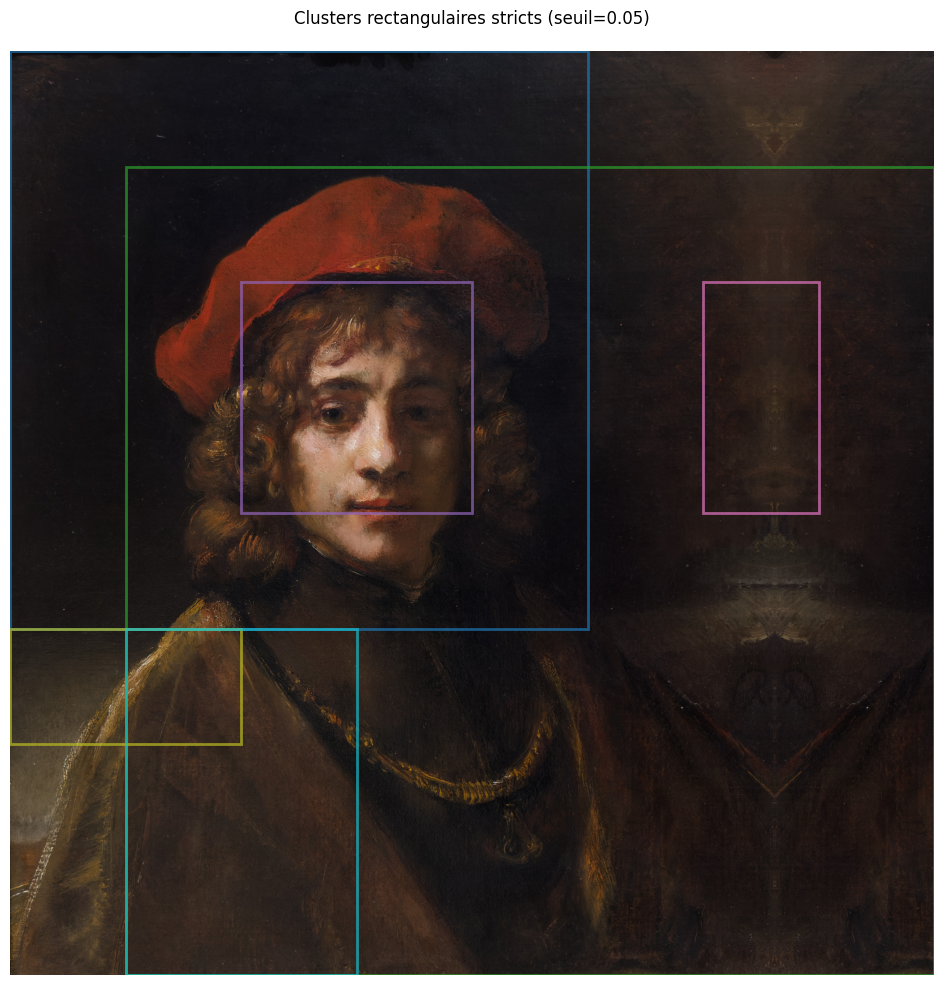

Zone 0:
- Nombre de patches: 39
- Position moyenne: [425.02564103 430.76923077]
Zone 1:
- Nombre de patches: 76
- Position moyenne: [960.84210526 928.42105263]
Zone 2:
- Nombre de patches: 7
- Position moyenne: [576. 544.]
Zone 3:
- Nombre de patches: 4
- Position moyenne: [1344.  560.]
Zone 4:
- Nombre de patches: 4
- Position moyenne: [ 112. 1120.]
Zone 5:
- Nombre de patches: 11
- Position moyenne: [ 346.18181818 1364.36363636]


In [160]:
# Obtenir les patches
patches_data = get__patches(index, idx=6467,show=True)

# Grouper les patches similaires adjacents
results = group_rectangular_similar_patches(patches_data, threshold=0.05, show=True)

# Analyser les résultats
for cluster_id, info in results['cluster_info'].items():
    if len(info['positions']) > 1:  # Filtrer les clusters significatifs
        print(f"Zone {cluster_id}:")
        print(f"- Nombre de patches: {len(info['positions'])}")
        print(f"- Position moyenne: {np.mean(info['positions'], axis=0)}")

In [141]:
def plot_clusters_separately(patches_dict, cluster_results):
    """
    Affiche chaque groupe de patches similaires séparément.
    
    Args:
        patches_dict: Dictionnaire retourné par get__patches()
        cluster_results: Résultat de group_adjacent_similar_patches()
    """
    n_clusters = cluster_results['n_clusters']
    patch_size = patches_dict['patch_size']
    
    for cluster_id in range(n_clusters):
        cluster_info = cluster_results['cluster_info'][cluster_id]
        if cluster_info['size'] < 2:  # On ignore les clusters isolés
            continue
            
        # Créer une image vide pour ce cluster
        positions = cluster_info['positions']
        x_coords = [pos[0] for pos in positions]
        y_coords = [pos[1] for pos in positions]
        
        # Calculer la taille de l'image composite
        cols = max(x//patch_size for x in x_coords) - min(x//patch_size for x in x_coords) + 1
        rows = max(y//patch_size for y in y_coords) - min(y//patch_size for y in y_coords) + 1
        
        # Créer l'image du cluster
        cluster_img = np.zeros((rows*patch_size, cols*patch_size, 3), dtype=np.uint8)
        
        # Remplir avec les patches
        for x, y in positions:
            patch = patches_dict['image'][y:y+patch_size, x:x+patch_size]
            grid_x = (x - min(x_coords)) // patch_size
            grid_y = (y - min(y_coords)) // patch_size
            cluster_img[grid_y*patch_size:(grid_y+1)*patch_size, 
                       grid_x*patch_size:(grid_x+1)*patch_size] = patch
        
        # Afficher le cluster
        plt.figure(figsize=(8, 8))
        plt.imshow(cluster_img)
        plt.axis('off')
        plt.title(f"Cluster {cluster_id}\nTaille: {cluster_info['size']} patches")
        plt.show()

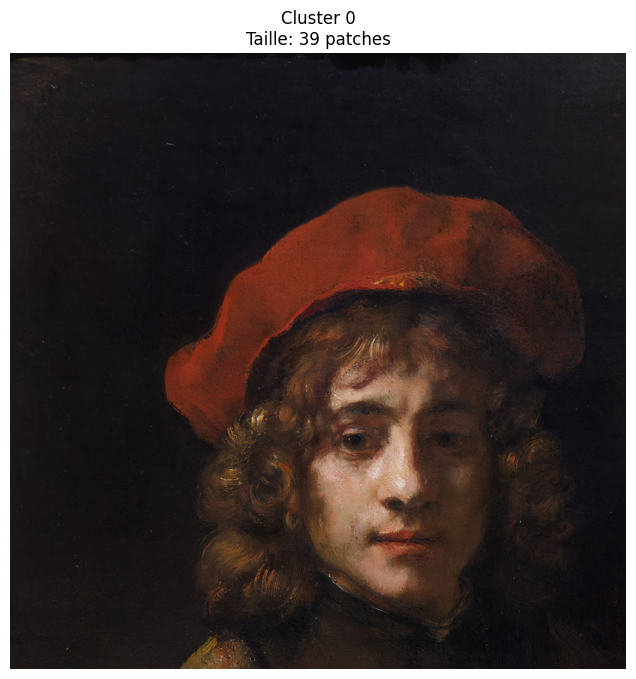

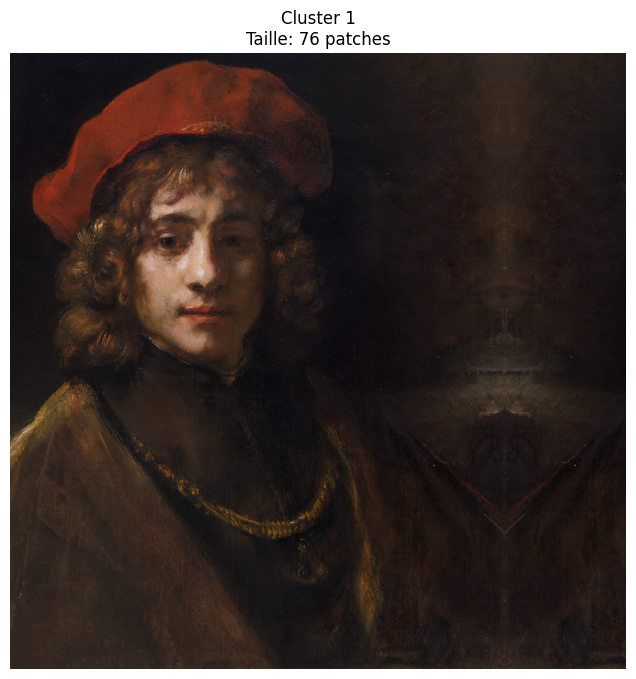

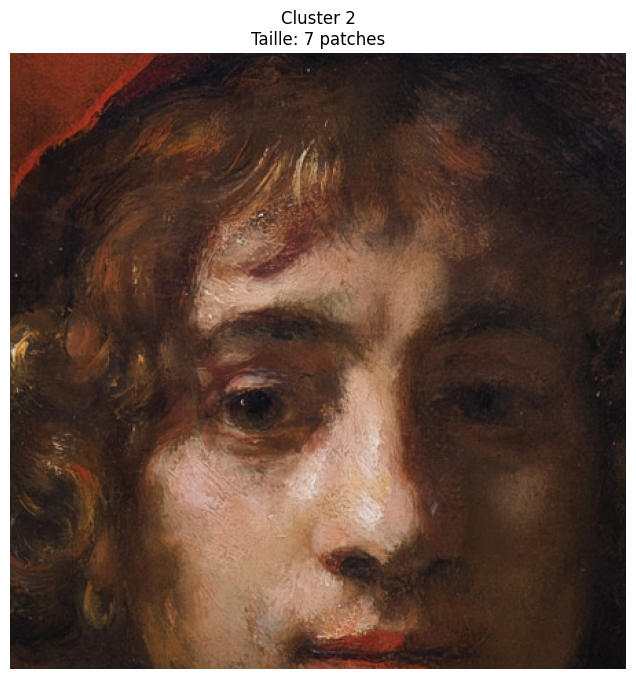

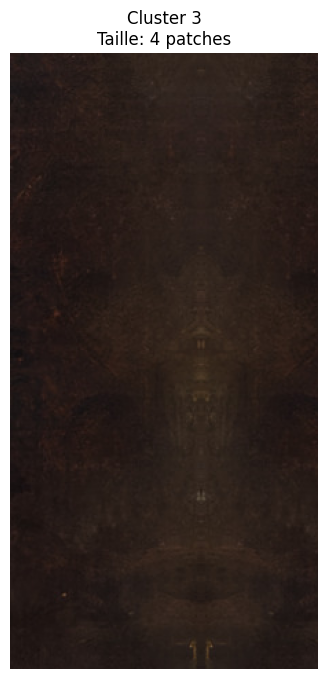

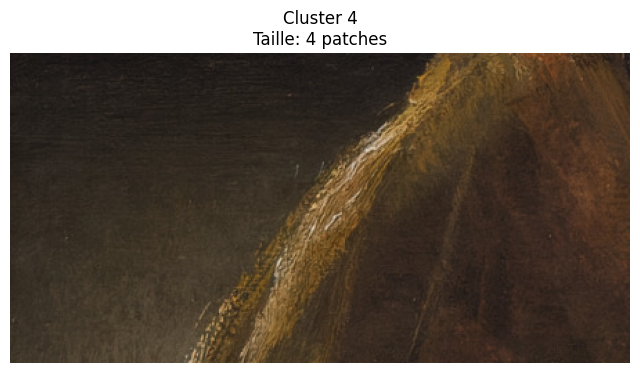

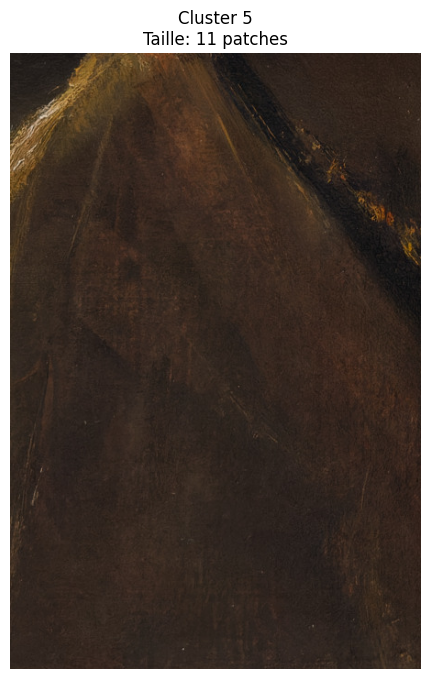

In [161]:
plot_clusters_separately(patches_data, results)

# Models

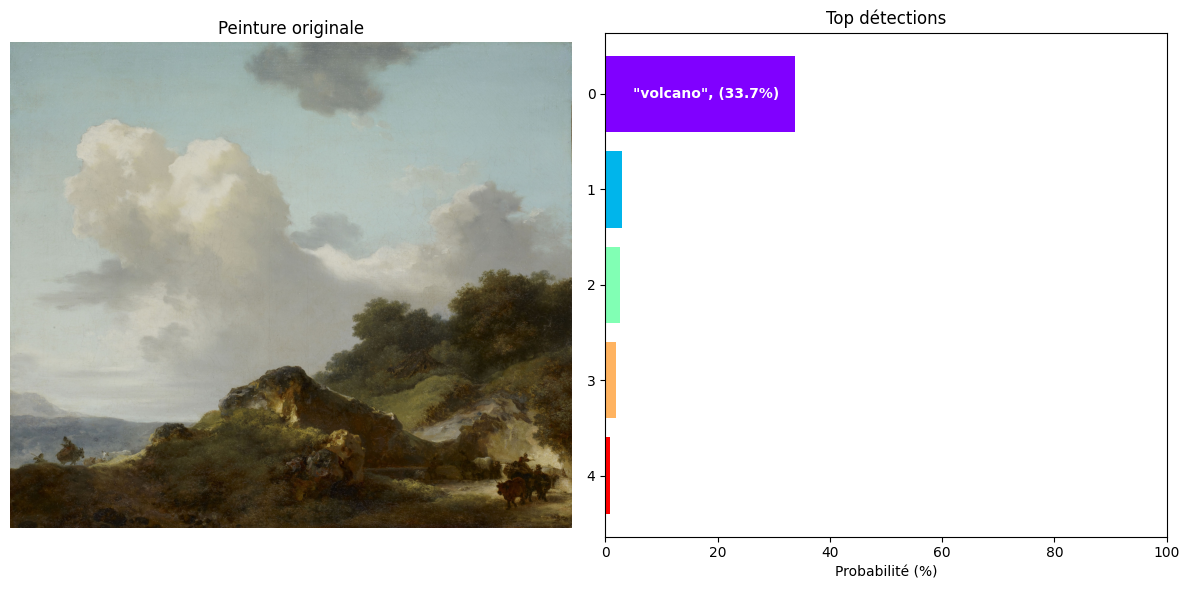

Détections principales: {'"volcano",': 0.33732953667640686, '"coral reef",': 0.0294044092297554, '"geyser",': 0.025829024612903595, '"cliff",': 0.01896856352686882, '"alp",': 0.008061203174293041}


In [133]:
from torchvision import transforms


# 1. Charger le modèle pré-entraîné
model = models.resnet50(weights='IMAGENET1K_V2')
model.eval()

# 2. Préparation de l'image
def prepare_image(image_path, target_size=224):
    """Préprocess l'image pour ResNet50"""
    transform = transforms.Compose([
        transforms.Resize(int(target_size * 1.15)),  # Légère surdimension
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    
    img = Image.open(image_path).convert('RGB')
    return transform(img).unsqueeze(0), img  # Ajoute une dimension de batch

# 3. Charger les classes ImageNet
with open('imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

# 4. Fonction de prédiction et visualisation
def analyze_painting(image_path, top_k=5):
    """Analyse une peinture et affiche les détections"""
    # Préparation
    input_tensor, original_img = prepare_image(image_path)
    
    # Prédiction
    with torch.no_grad():
        outputs = model(input_tensor)
    
    # Interprétation
    probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    top_probs, top_indices = torch.topk(probabilities, top_k)
    
    # Affichage
    plt.figure(figsize=(12, 6))
    
    # Image originale
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Peinture originale')
    plt.axis('off')
    
    # Résultats
    plt.subplot(1, 2, 2)
    colors = plt.cm.rainbow(np.linspace(0, 1, top_k))
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        plt.barh(i, prob.item() * 100, color=colors[i])
        plt.text(5, i, 
                f"{classes[idx.item()]} ({prob.item()*100:.1f}%)",
                va='center', color='white', fontweight='bold')
    
    plt.gca().invert_yaxis()
    plt.title('Top détections')
    plt.xlabel('Probabilité (%)')
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()

    return {classes[idx.item()]: prob.item() for idx, prob in zip(top_indices, top_probs)}

# 5. Exemple d'utilisation
results = analyze_painting(list(index.keys())[2697])  # Analyse la 10ème image
print("Détections principales:", results)

Using cache found in C:\Users\Titouan/.cache\torch\hub\facebookresearch_WSL-Images_main


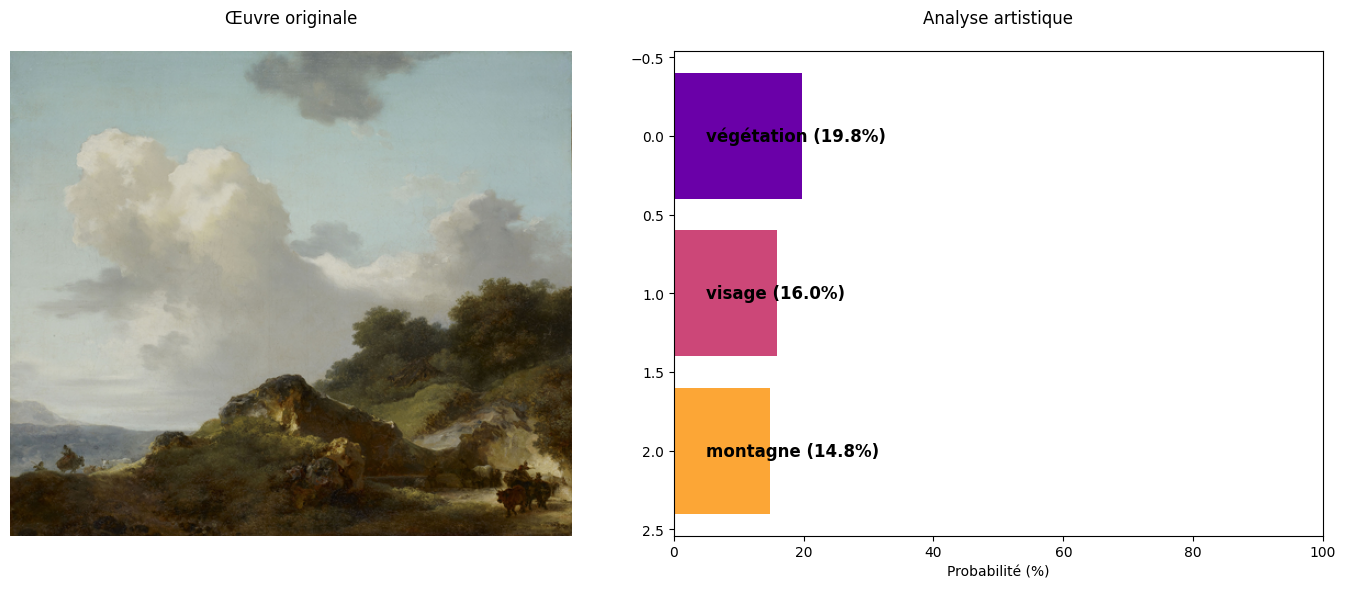

In [134]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 1. Charger un modèle spécialisé dans l'art (via torch.hub)
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
model.eval()

# 2. Classes plus adaptées aux peintures (exemple simplifié)
art_classes = [
    'visage', 'portrait', 'paysage', 'nature_morte', 
    'nu', 'scène_historique', 'abstrait', 'animaux',
    'architecture', 'intérieur', 'mer', 'montagne',
    'végétation', 'objet_religieux', 'instrument_musique'
]

# 3. Transformation optimisée pour l'art
def art_transform(image_path, size=512):
    """Prétraitement qui préserve les détails artistiques"""
    img = Image.open(image_path).convert('RGB')
    
    # Conservation du ratio original + padding intelligent
    ratio = min(size/img.size[0], size/img.size[1])
    new_size = (int(img.size[0]*ratio), int(img.size[1]*ratio))
    img = img.resize(new_size, Image.LANCZOS)
    
    # Création d'un canvas carré avec remplissage contextuel
    new_img = Image.new('RGB', (size, size), (114, 114, 114))
    new_img.paste(img, ((size-new_size[0])//2, (size-new_size[1])//2))
    
    # Normalisation spécifique
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(new_img).unsqueeze(0), img

# 4. Analyse avec interprétation artistique
def analyze_art(image_path, top_k=3):
    """Version améliorée pour l'analyse artistique"""
    tensor, original_img = art_transform(image_path)
    
    with torch.no_grad():
        features = model(tensor)
    
    # Simulation de prédictions (à remplacer par votre classifieur)
    probs = torch.randn(len(art_classes)).softmax(dim=0) * 100
    top_probs, top_indices = torch.topk(probs, top_k)
    
    # Visualisation
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Œuvre originale', pad=20)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    colors = plt.cm.plasma(np.linspace(0.2, 0.8, top_k))
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        plt.barh(i, prob.item(), color=colors[i])
        plt.text(5, i, 
                f"{art_classes[idx]} ({prob.item():.1f}%)",
                va='center', fontsize=12, fontweight='bold')
    
    plt.gca().invert_yaxis()
    plt.title('Analyse artistique', pad=20)
    plt.xlabel('Probabilité (%)')
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
analyze_art(list(index.keys())[2697])